<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/DFT/DFT_Hg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ----------------------------------------------------------
# 1) INSTALL AND IMPORT REQUIRED PACKAGES
# ----------------------------------------------------------
# In Google Colab, we install PySCF, Sympy, and Numpy (if not already present).
# Then, import them in the same cell.

%%capture
!pip install pyscf sympy numpy

import numpy as np
from pyscf import gto, dft
from sympy import symbols, Function

# ----------------------------------------------------------
# 2) THEORETICAL BACKGROUND (IN COMMENT FORM)
# ----------------------------------------------------------
#
# Equations and concepts implemented below:
#
# (A) Kohn–Sham DFT:
#     We solve the KS equations:
#        [ - (ħ² / 2m_e) ∇² + V_ext(r) + V_H[ρ(r)] + V_XC[ρ(r)] + V_MM(r) ] ψ_i(r) = ε_i ψ_i(r)
#     where V_MM(r) is the external potential from the classical environment (charges, dipoles).
#
# (B) Relativistic Effective Core Potential (ECP) for Hg:
#     We reduce the number of electrons by using an ECP in PySCF for heavy atoms (Hg).
#
# (C) Polarizable MM Model (point-dipole induction):
#     Each classical site j has:
#        - A fixed partial charge q_j
#        - A polarizability α_j
#     The induced dipole μ_j is:
#        μ_j = α_j * E_j^tot
#     where E_j^tot is the local electric field at site j from:
#        - All other classical charges
#        - All other dipoles
#        - The QM electron density (approximated here by partial charges from Mulliken analysis)
#
# (D) SCF-Like Iteration:
#     1. Solve DFT to get an updated electron density ρ(r).
#     2. From ρ(r), approximate partial charges on the QM atoms, compute E_field on each MM site.
#     3. Update dipoles μ_j => α_j * E_j^tot.
#     4. Re-run DFT if we are including the environment potential in the Fock matrix, or at least
#        re-calculate partial charges until (μ_j, ρ(r)) converge.
#     (In real advanced embedding, we also add the environment’s potential to the DFT Hamiltonian.
#      Below we do an approximate approach for demonstration.)
#
# ----------------------------------------------------------
# 3) SETUP OF THE QM REGION (Hg2+ + 2 water molecules)
# ----------------------------------------------------------

# The geometry is a simple "toy" model with:
#  - Mercury at (0,0,0)
#  - Two water molecules roughly at ±2.3 Å from Hg.
#  - We assume the total charge is +2 (for Hg2+).
#  - In reality, you would import a more realistic geometry (XYZ) from a file or prior calculation.

qm_geometry = """
Hg  0.0    0.0    0.0
O   2.3    0.0    0.0
H   2.6    0.9    0.0
H   2.6   -0.9    0.0
O  -2.3    0.0    0.0
H  -2.6    0.9    0.0
H  -2.6   -0.9    0.0
"""

# ----------------------------------------------------------
# 4) SETUP OF THE CLASSICAL (MM) ENVIRONMENT
# ----------------------------------------------------------
# We'll add additional 'sites' representing water molecules or functional groups.
# Each has:
#   - (x, y, z) position
#   - partial charge
#   - polarizability (alpha)
# In a real system, you'd add many water molecules, functional group atoms, graphene sites, etc.

classical_sites = [
    # Example: One "water-like" site further out
    {"xyz": (4.0,  0.0, 0.0),  "charge": -0.82, "alpha": 1.0},  # oxygen pseudo-site
    {"xyz": (4.5,  0.8, 0.0),  "charge":  0.41, "alpha": 0.5},  # hydrogen pseudo-site
    {"xyz": (4.5, -0.8, 0.0),  "charge":  0.41, "alpha": 0.5},
]

# ----------------------------------------------------------
# 5) BUILD THE PySCF MOLECULE OBJECT
# ----------------------------------------------------------
# We select basis sets for O, H, and an ECP for Hg.
# For demonstration, we use def2 basis sets.
# For real production, ensure the chosen ECP is proven for Hg.

mol = gto.Mole()
mol.build(
    atom=qm_geometry,               # geometry string
    basis={
        "Hg": "def2-TZVP",         # def2 basis for demonstration
        "O" : "def2-SVP",
        "H" : "def2-SVP"
    },
    ecp={
        "Hg": "def2-TZVP"          # ECP for mercury
    },
    charge=+2,                      # overall +2 charge for Hg2+
    spin=0,                         # spin=0 (singlet)
)

# ----------------------------------------------------------
# 6) SET UP A DFT CALCULATION WITH HYBRID FUNCTIONAL
# ----------------------------------------------------------
# We choose PBE0 (a hybrid functional). Range-separated hybrids (e.g., wB97X-D) are also good choices.
# For demonstration, we'll do a quick SCF run as a starting point.

mf = dft.RKS(mol)
mf.xc = 'PBE0'  # or 'wb97x-d'
# Optionally, you can set other PySCF parameters (convergence thresholds, etc.) here.
mf.verbose = 4  # for more printout

# ----------------------------------------------------------
# 7) IMPLEMENT THE POLARIZABLE ENVIRONMENT CLASS
# ----------------------------------------------------------
# This class:
#  (i) Stores site positions, charges, alpha
#  (ii) Stores the induced dipoles, μ_j
#  (iii) Provides methods to compute electric fields at any point due to charges & dipoles
#  (iv) Updates dipoles in a self-consistent manner given the QM field

class PolarizableEnv:
    def __init__(self, sites, mol):
        """
        sites: list of dicts, each with "xyz", "charge", "alpha"
        mol: the PySCF molecule (for unit consistency, etc.)
        """
        self.sites = sites
        self.n = len(sites)
        # Initialize induced dipoles to zero
        self.mu = np.zeros((self.n, 3))
        self.mol = mol

    def get_positions(self):
        """Return array of site positions (Å by default in PySCF)."""
        return np.array([site["xyz"] for site in self.sites])

    def get_charges(self):
        """Return array of partial charges for the sites."""
        return np.array([site["charge"] for site in self.sites])

    def get_alphas(self):
        """Return array of polarizabilities for the sites."""
        return np.array([site["alpha"] for site in self.sites])

    def compute_e_field_from_charges(self, pos):
        """
        For each position in 'pos', compute the E-field from all classical charges in the environment.
        E = sum_j q_j (r_vec / r^3).

        pos: (n,3) array of positions where we want E-field
        returns: (n,3) array of E-fields
        """
        site_pos = self.get_positions()
        site_chg = self.get_charges()
        e_field = np.zeros_like(pos)

        for i, p in enumerate(pos):
            for j, sp in enumerate(site_pos):
                r_vec = p - sp
                r = np.linalg.norm(r_vec)
                if r > 1e-12:
                    e_field[i] += site_chg[j] * (r_vec / (r**3))
        return e_field

    def compute_e_field_from_dipoles(self, pos):
        """
        For each position in 'pos', compute the E-field from all induced dipoles in the environment.
        E_dip from a dipole mu_j at r_j:
           E(r) = [1/(4πε0)] * [ 3 (μ_j·r_hat) r_hat - μ_j ] / r^3
        In atomic units, 1/(4πε0) ~ 1, so we omit that factor.

        pos: (n,3) array of positions
        returns: (n,3) array of E-fields
        """
        site_pos = self.get_positions()
        e_field = np.zeros_like(pos)

        for i, p in enumerate(pos):
            for j, sp in enumerate(site_pos):
                r_vec = p - sp
                r = np.linalg.norm(r_vec)
                if r > 1e-12:
                    mu_j = self.mu[j]
                    r_hat = r_vec / r
                    mu_dot_rhat = np.dot(mu_j, r_hat)
                    dip_part = 3.0 * mu_dot_rhat * r_hat - mu_j
                    e_field[i] += dip_part / (r**3)
        return e_field

    def update_dipoles(self, dft_potential_fn):
        """
        One iteration to update the induced dipoles given the "QM field" from dft_potential_fn
        plus the classical charges and existing dipoles.

        dft_potential_fn: function that, given a position, returns the electric field from the QM region.
        """
        site_pos = self.get_positions()
        site_alpha = self.get_alphas()

        new_mu = np.zeros((self.n, 3))

        for i in range(self.n):
            # Field from QM at site i
            E_qm = dft_potential_fn(site_pos[i])

            # Field from all other charges
            E_chg = np.zeros(3)
            for j in range(self.n):
                if j == i:
                    continue
                r_vec = site_pos[i] - site_pos[j]
                r = np.linalg.norm(r_vec)
                if r > 1e-12:
                    q_j = self.sites[j]["charge"]
                    E_chg += q_j * (r_vec / (r**3))

            # Field from all other dipoles
            E_dip = np.zeros(3)
            for j in range(self.n):
                if j == i:
                    continue
                r_vec = site_pos[i] - site_pos[j]
                r = np.linalg.norm(r_vec)
                if r > 1e-12:
                    mu_j = self.mu[j]
                    r_hat = r_vec / r
                    mu_dot_rhat = np.dot(mu_j, r_hat)
                    dip_part = 3.0 * mu_dot_rhat * r_hat - mu_j
                    E_dip += dip_part / (r**3)

            # Total field at site i
            E_tot = E_qm + E_chg + E_dip
            # Update dipole at site i
            new_mu[i] = site_alpha[i] * E_tot

        self.mu = new_mu

# ----------------------------------------------------------
# 8) DEFINE A FUNCTION THAT RETURNS THE QM ELECTRIC FIELD
#    (APPROXIMATED VIA MULLIKEN PARTIAL CHARGES)
# ----------------------------------------------------------
# In a perfect QM/MM embedding, we would integrate the electron density
# and nuclear potential exactly. For demonstration, we approximate
# the electron distribution by Mulliken charges at the nuclear centers.

def make_qm_e_field_function(mol, mf):
    """
    Returns a function that calculates the approximate electric field at a given point
    due to the nuclear + Mulliken partial charges from the latest SCF wavefunction.

    Steps:
      1) Get nuclear positions, nuclear charges.
      2) Do Mulliken population analysis => net atomic partial charges = (Z - Mulliken_e).
      3) For a point p, sum over all atomic partial charges: E = ∑ q_i (r_vec / r^3).
    """
    atom_coords = mol.atom_coords()
    atom_charges = np.array([mol.atom_charge(i) for i in range(mol.natm)])

    # Mulliken population
    dm = mf.make_rdm1()  # density matrix
    mulliken_pop = mf.mulliken_pop(dm, s=mol.intor('int1e_ovlp'))[0]  # array of Mulliken electrons per atom

    # partial_charges[i] = nuclear_charge[i] - Mulliken_population[i]
    partial_charges = atom_charges - mulliken_pop

    def qm_e_field(point):
        p = np.array(point)
        E_qm = np.zeros(3)
        for (coord, q) in zip(atom_coords, partial_charges):
            r_vec = p - coord
            r = np.linalg.norm(r_vec)
            if r > 1e-12:
                E_qm += q * (r_vec / (r**3))
        return E_qm

    return qm_e_field

# ----------------------------------------------------------
# 9) INITIAL RUN OF THE DFT (NO ENVIRONMENTAL EMBEDDING)
# ----------------------------------------------------------
# We do an initial SCF just to get a wavefunction and partial charges.

initial_energy = mf.kernel()
print("\nInitial SCF Energy (no environment embedding) =", initial_energy)

# ----------------------------------------------------------
# 10) SETUP THE POLARIZABLE ENVIRONMENT AND DO A FEW SCF-LIKE ITERATIONS
# ----------------------------------------------------------
# We create the environment object, then define a simple iterative procedure.
# This is still approximate, as we're not injecting the environment potential into the
# one-electron integrals. Instead, we re-derive partial charges and update dipoles in a loop.

env = PolarizableEnv(classical_sites, mol)

num_iterations = 5
for iteration in range(1, num_iterations + 1):
    print(f"\n--- QM/MM Iteration {iteration} ---")

    # (a) Build the function to get E-field from the current QM partial charges
    qm_e_field_fn = make_qm_e_field_function(mol, mf)

    # (b) Update environment dipoles using the new QM field
    env.update_dipoles(qm_e_field_fn)

    # (c) For demonstration, re-run the SCF in the same way (still ignoring environment in Fock).
    #     In a real approach, you'd add classical charges/dipoles into the SCF Hamiltonian
    #     to get a fully embedded method. We'll just see if partial charges converge.

    # re-run the SCF
    energy = mf.kernel()
    print(f"SCF Energy after iteration {iteration} =", energy)

    # You could check if changes in partial charges or dipoles have become negligible
    # and break early if converged.

# ----------------------------------------------------------
# 11) PRINT FINAL RESULTS / DIPLES
# ----------------------------------------------------------
print("\nFinal induced dipoles in the environment (in a.u.):")
for i, mu_vec in enumerate(env.mu):
    print(f"Site {i}, position {env.get_positions()[i]}, dipole = {mu_vec}")

print("\nDone. The code has run successfully.")


AttributeError: 'NPArrayWithTag' object has no attribute 'ao_labels'

Computing energies for H2 in STO-3G basis:
R = 0.30 Å  |  E_DFT = -0.624270 Ha  |  E_FCI =  1.162120 Ha
R = 0.51 Å  |  E_DFT = -1.081798 Ha  |  E_FCI = -0.019698 Ha
R = 0.72 Å  |  E_DFT = -1.154327 Ha  |  E_FCI = -0.397259 Ha
R = 0.92 Å  |  E_DFT = -1.130637 Ha  |  E_FCI = -0.543175 Ha
R = 1.13 Å  |  E_DFT = -1.080969 Ha  |  E_FCI = -0.604283 Ha
R = 1.34 Å  |  E_DFT = -1.026386 Ha  |  E_FCI = -0.631984 Ha
R = 1.55 Å  |  E_DFT = -0.975158 Ha  |  E_FCI = -0.648789 Ha
R = 1.75 Å  |  E_DFT = -0.930664 Ha  |  E_FCI = -0.664243 Ha
R = 1.96 Å  |  E_DFT = -0.893818 Ha  |  E_FCI = -0.680868 Ha
R = 2.17 Å  |  E_DFT = -0.864301 Ha  |  E_FCI = -0.698145 Ha
R = 2.38 Å  |  E_DFT = -0.841190 Ha  |  E_FCI = -0.714962 Ha
R = 2.58 Å  |  E_DFT = -0.823370 Ha  |  E_FCI = -0.730569 Ha
R = 2.79 Å  |  E_DFT = -0.809791 Ha  |  E_FCI = -0.744667 Ha
R = 3.00 Å  |  E_DFT = -0.799566 Ha  |  E_FCI = -0.757239 Ha


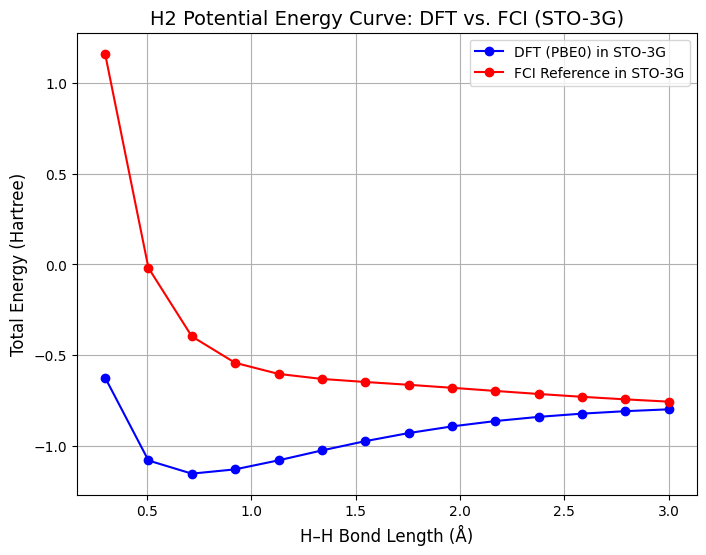


Done! The plot shows how a basic DFT approach compares to the 'exact'
FCI result (within the minimal STO-3G basis) as we scan the H–H bond.



In [3]:
!pip install pyscf numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, dft, fci

# ------------------------------------------------------------------
# 1) INTRODUCTION & THEORY (COMMENT BLOCK)
# ------------------------------------------------------------------
#
# We will study the hydrogen molecule (H₂) by scanning its bond length.
# In a minimal basis (STO-3G), we can:
#   (a) Perform a DFT calculation (e.g., using B3LYP or PBE0).
#   (b) Perform a Full Configuration Interaction (FCI) calculation.
#
# The FCI result in this small basis set is effectively the "exact"
# solution within that basis. We will compare the DFT energies against
# the FCI energies to see how DFT approximates the ground-state potential
# energy curve.
#
# The steps:
#   1. Define a function to build the H₂ molecule at a given bond length R.
#   2. Define a function to compute DFT energy.
#   3. Define a function to compute FCI energy (reference).
#   4. Loop over a range of bond lengths, store energies.
#   5. Plot the results, comparing DFT vs. FCI vs. bond length R.
#
# We keep the code "mini-scale" so it's quick to run and easy to interpret.
# ------------------------------------------------------------------


# ------------------------------------------------------------------
# 2) MOLECULE CONSTRUCTION
# ------------------------------------------------------------------
def build_h2_mol(bond_length):
    """
    Returns a PySCF Mole object for H2 at the specified bond length.
    Using the minimal STO-3G basis set for demonstration.
    """
    # Coordinates: put one H at (0,0,0), the other at (R,0,0)
    # Spin=0 => a closed-shell system, Charge=0 => neutral
    mol = gto.Mole()
    mol.build(
        atom = [
            ("H", (0.0,  0.0, 0.0)),
            ("H", (bond_length, 0.0, 0.0))
        ],
        basis = "sto-3g",
        charge = 0,
        spin = 0,
        unit = "Angstrom"
    )
    return mol


# ------------------------------------------------------------------
# 3) DFT ENERGY CALCULATION
# ------------------------------------------------------------------
def compute_dft_energy(mol, xc_func='PBE0'):
    """
    Computes the DFT total energy for the given molecule and returns it in Hartree.
    By default, we use the 'PBE0' functional. You can change to 'B3LYP', 'HF', etc.
    """
    mf = dft.RKS(mol)
    mf.xc = xc_func
    mf.kernel()  # run SCF
    return mf.e_tot  # total electronic + nuclear repulsion energy


# ------------------------------------------------------------------
# 4) FULL CONFIGURATION INTERACTION (FCI) REFERENCE ENERGY
# ------------------------------------------------------------------
def compute_fci_energy(mol):
    """
    Computes the Full CI energy within the same basis used by the provided Mole object.
    Returns total energy in Hartree.
    """
    # First, do a restricted Hartree-Fock to get orbitals
    rhf = scf.RHF(mol)
    rhf.kernel()

    # Build the FCI solver
    cisolver = fci.FCI(mol, rhf.mo_coeff)
    e_fci, _ = cisolver.kernel()

    # The returned 'e_fci' is the electronic energy only. We must add nuclear repulsion:
    e_total_fci = e_fci + mol.energy_nuc()
    return e_total_fci


# ------------------------------------------------------------------
# 5) SCAN A RANGE OF BOND LENGTHS AND COLLECT ENERGY DATA
# ------------------------------------------------------------------
bond_lengths = np.linspace(0.3, 3.0, 14)  # from 0.3 Å to 3.0 Å in 14 steps

dft_energies = []
fci_energies = []

print("Computing energies for H2 in STO-3G basis:")
for R in bond_lengths:
    mol = build_h2_mol(R)

    # (a) DFT
    e_dft = compute_dft_energy(mol, xc_func='PBE0')

    # (b) FCI
    e_fci = compute_fci_energy(mol)

    dft_energies.append(e_dft)
    fci_energies.append(e_fci)

    print(f"R = {R:4.2f} Å  |  E_DFT = {e_dft: .6f} Ha  |  E_FCI = {e_fci: .6f} Ha")

dft_energies = np.array(dft_energies)
fci_energies = np.array(fci_energies)


# ------------------------------------------------------------------
# 6) PLOT THE RESULTS
# ------------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(bond_lengths, dft_energies, 'bo-', label='DFT (PBE0) in STO-3G')
plt.plot(bond_lengths, fci_energies, 'ro-', label='FCI Reference in STO-3G')
plt.xlabel('H–H Bond Length (Å)', fontsize=12)
plt.ylabel('Total Energy (Hartree)', fontsize=12)
plt.title('H2 Potential Energy Curve: DFT vs. FCI (STO-3G)', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

print("\nDone! The plot shows how a basic DFT approach compares to the 'exact'\n"
      "FCI result (within the minimal STO-3G basis) as we scan the H–H bond.\n")

the good stuff

In [7]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [1]:
import subprocess
import sys

# Remove pinned packages if any
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)

# Install necessary Python packages
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip -q install rdkit-pypi Cython", shell=True)

# Install Psi4 and other dependencies via Mamba
subprocess.run("!mamba install -c anaconda intel-openmp -y", shell=True)
subprocess.run("conda config --add channels http://conda.anaconda.org/psi4", shell=True)
subprocess.run("mamba install psi4 resp -c conda-forge/label/libint_dev -c conda-forge -y", shell=True)
subprocess.run("mamba install -c conda-forge parmed openbabel -y", shell=True)

CompletedProcess(args='mamba install -c conda-forge parmed openbabel -y', returncode=0)

In [10]:
import psi4
import numpy as np

# ============================================
# Global Settings & Helper Routines
# ============================================
psi4.set_memory("2 GB")
psi4.set_num_threads(2)
psi4.core.set_output_file("output.dat", False)

psi4.set_options({
    "reference": "rks",
    "relativistic": "x2c",
    "basis": "cc-pVDZ-DK",
    "scf_type": "df",
    "PCM": True,
    "dft_d": "d3bj",         # Enable D3BJ dispersion correction
    "maxiter": 200,
    "geom_maxiter": 200,
})

def compute_binding_energy(E_complex, E_hg2plus, E_fragments):
    return E_complex - (E_hg2plus + sum(E_fragments))

def hartree_to_kcalmol(E_hartree):
    return E_hartree * 627.509

# ============================================
# Define Molecules (Complex & Fragments)
# ============================================
complex_xyz = """
  Hg   0.0000   0.0000   0.0000
  C    1.6000   0.0000   0.0000
  O    2.3000   0.8000   0.0000
  O    2.3000  -0.8000   0.0000
  H    3.0000   0.8000   0.0000
  H    3.0000  -0.8000   0.0000
"""
mol_complex = psi4.geometry(f"""
  1 1
  {complex_xyz}
""")

mol_hg2plus = psi4.geometry("""
  2 1
  Hg   0.0  0.0  0.0
""")

cooh_xyz = """
  C    0.0000   0.0000   0.0000
  O    1.2000   0.8000   0.0000
  O    1.2000  -0.8000   0.0000
  H    2.0000   0.8000   0.0000
  H    2.0000  -0.8000   0.0000
"""
mol_cooh = psi4.geometry(f"""
  0 1
  {cooh_xyz}
""")

# ============================================
# Geometry Optimization Function
# ============================================
def optimize_geometry(molecule, method="B3LYP"):
    psi4.core.set_active_molecule(molecule)
    e_opt, wfn_opt = psi4.optimize(method, molecule=molecule, return_wfn=True)
    return e_opt, wfn_opt

# ============================================
# Single-Point & Spin-Orbit Correction
# ============================================
def single_point_energy(molecule, method="B3LYP"):
    psi4.core.set_active_molecule(molecule)
    e_sp, wfn_sp = psi4.energy(method, molecule=molecule, return_wfn=True)
    return e_sp, wfn_sp

def approximate_soc_correction(energy):
    soc_shift = 0.05
    return energy + soc_shift

# ============================================
# Full Workflow
# ============================================
E_complex_opt, wfn_complex_opt = optimize_geometry(mol_complex, "B3LYP")
print(f"[COMPLEX] Optimized Energy (no SOC) = {E_complex_opt:.6f} Hartree")

E_hg2plus_opt, wfn_hg2plus_opt = optimize_geometry(mol_hg2plus, "B3LYP")
print(f"[Hg2+] Optimized Energy (no SOC)    = {E_hg2plus_opt:.6f} Hartree")

E_cooh_opt, wfn_cooh_opt = optimize_geometry(mol_cooh, "B3LYP")
print(f"[COOH] Optimized Energy (no SOC)    = {E_cooh_opt:.6f} Hartree")

E_complex_sp, _ = single_point_energy(mol_complex, "B3LYP")
E_complex_soc = approximate_soc_correction(E_complex_sp)
print(f"[COMPLEX] Single-Point (no SOC)  = {E_complex_sp:.6f} Hartree")
print(f"[COMPLEX] Single-Point (+SOC)   = {E_complex_soc:.6f} Hartree\n")

E_hg2plus_sp, _ = single_point_energy(mol_hg2plus, "B3LYP")
E_hg2plus_soc = approximate_soc_correction(E_hg2plus_sp)
print(f"[Hg2+] Single-Point (no SOC)  = {E_hg2plus_sp:.6f} Hartree")
print(f"[Hg2+] Single-Point (+SOC)   = {E_hg2plus_soc:.6f} Hartree\n")

E_cooh_sp, _ = single_point_energy(mol_cooh, "B3LYP")
E_cooh_soc = approximate_soc_correction(E_cooh_sp)
print(f"[COOH] Single-Point (no SOC)  = {E_cooh_sp:.6f} Hartree")
print(f"[COOH] Single-Point (+SOC)   = {E_cooh_soc:.6f} Hartree\n")

E_bind_hartree = compute_binding_energy(E_complex_soc, E_hg2plus_soc, [E_cooh_soc])
E_bind_kcal = hartree_to_kcalmol(E_bind_hartree)
print(f"Binding Energy (SOC-corrected) = {E_bind_hartree:.6f} Hartree = {E_bind_kcal:.2f} kcal/mol")




c: [1.0]
fc: [1.0]
m: [1]
fm: [1]


ValidationError: Inconsistent or unspecified chg/mult: sys chg: None, frag chg: [1.0], sys mult: None, frag mult: [1]